### Finding Optimal Shared Streets Code Tutorial
#### Coauthors
#### Emma Gibbs,  MIchael Schmidt, Evan Shapiro

This is a tutorial that is complimentary to our project for finding optimal streets in Denver to convert into Shared Streets. We attempted to identify Denver neighborhoods that will benefit most from an improved walking and biking experience by using equity scores and pedestrian demand index scores accessed throught the Denver Open Data Catalog.  
We define optimal streets to be the streets in a neighborhood that on average, when removed, have the least impact on traffic flow in the surrounding area. Please refer to our project slides for how we define equitable, and choose neighborhoods in an equitable manner.  




# Tutorial Outline:   
- Import all data necessary for identifying neighborhoods of interest based on neighborhood equity data, pedestrian demand index Data, traffic accident data, and key destination data from the Denver Open Data Catalog.
- Use the above data to identify candidate neighborhoods and streets.
- Using "" method, assign traffic flow capacities to the candidate streets for analysis.    
- Run the All Pairs Max-Flow algorithm in Networkxto identify which of the candidate streets, on average, have the lowest impact on traffic flow when removed from the street network.  

### Tutorial Requirements:
- To run this Jupyter notebook tutorial you need to have Python 3.-, Jupyter Notebook, NetworkX, Geopandas, and OSMnx installed on your computer.  

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.ops import unary_union
import seaborn as sns
import numpy as np
from matplotlib import cm, colors
import matplotlib.pyplot as plt

# Enable OSMNX cache
ox.config(use_cache=True)
import util

### Neighborhood and Street Selection
Please refer to the <a href=https://github.com/schmidmt/Finding-Optional-Shared-Streets/blob/main/notebooks/BestNeighborhoodsStreets.ipynb>Best Neighborhoods Shared Streets ,</a> Jupyter Notebook for this part of the tutorial.

To choose candidate neighborhoods and streets we consider [Boulder's Low-Stress Walk and Bike Network Plan,](https://bouldercolorado.gov/projects/low-stress-walk-and-bike-network-plan) by [this paper:](https://bouldercolorado.gov/media/4530/download?inline=)

On page 34, the paper indicates that roads are chosen based on the following criteria:
* Equity index; areas with a lower equity index are valued more. Here is [Denver's equity index data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-equity-index-2020-neighborhood)
* Population and employment density; higher density neighborhoods are valued more.
  * Population and employment density are considered as part of the [Pedestrian Demand Index.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-pedestrian-demand-index)
* Density of crashes; more heavily weighted for pedestrian or bicyclist-involved crashes. Here is [Denver's crash data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents)
* Key destinations; the paper specifies parks, schools, and high-frequency transit stops, though it also indicates libraries, fitness centers, trailheads, restaurants, cafes, and grocery stores.
  * [Here](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-parks) is park data, [here](https://mygeodata.cloud/data/download/osm/schools/united-states-of-america--colorado/denver-county/denver) is school data, and [here](https://gis-rtd-denver.opendata.arcgis.com/maps/e14366d810644a3c95a4f3770799bd54/about) is RTD transit stop data.

Neighborhood Equity Data and Pedestrian Demand Index Data are imported from the Denver Open Data Catalog. This data is used to determine neighborhoods that have both low equity index scores, and high pedestrian demand index scores.  
   


# Neighborhood Selection

## Storing Equity Data

In [2]:
equity_data = gpd.read_file("../data/equity_index_2020___neighborhood.gdb", driver="OpenFileGDB")
equity_data.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,SHAPE_Length,SHAPE_Area,geometry
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339..."
1,Harvey Park,2.0,2.5,2.0,3.0,1.5,2.2,0.105342,0.000458,"MULTIPOLYGON (((-105.02511 39.66772, -105.0260..."
2,Mar Lee,2.0,1.5,2.5,2.0,3.5,2.3,0.085462,0.000410,"MULTIPOLYGON (((-105.02506 39.69675, -105.0250..."
3,East Colfax,1.5,1.5,3.5,1.0,2.0,1.9,0.073874,0.000291,"MULTIPOLYGON (((-104.88466 39.74746, -104.8846..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."


Plotting Neighborhoods by Equity Index Score
    

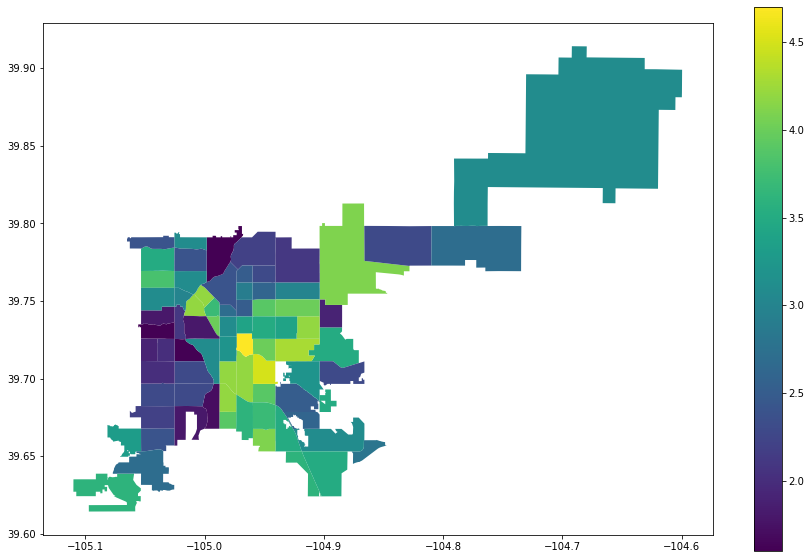

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="OVERALLEQUITY_SCORE", ax=ax, legend=True);

## Pedestrian Demand Data 

Storing pedestrian demand data.

In [7]:
pedestrian_data = gpd.read_file("../data/pedestrian_demand_index.gdb", driver="OpenFileGDB")
pedestrian_data.head()

,GEOID10,PDI_Score,PDI_Ranking,SHAPE_Length,SHAPE_Area,geometry
0,0803100412146,10,HIGH,0.005259,0.000002,"MULTIPOLYGON (((-104.99272 39.74744, -104.9929..."
1,0803100409310,8,HIGH,0.033493,0.000064,"MULTIPOLYGON (((-104.95938 39.66789, -104.9593..."
2,0803100410310,1,LOW,0.031635,0.000046,"MULTIPOLYGON (((-104.85573 39.66044, -104.8556..."
3,0803100407030,8,HIGH,0.040299,0.000073,"MULTIPOLYGON (((-104.89524 39.73595, -104.8952..."
4,0803100410130,8,HIGH,0.039525,0.000073,"MULTIPOLYGON (((-104.91274 39.67846, -104.9127..."


Plotting neighborhoods by pedestrian demand index score.

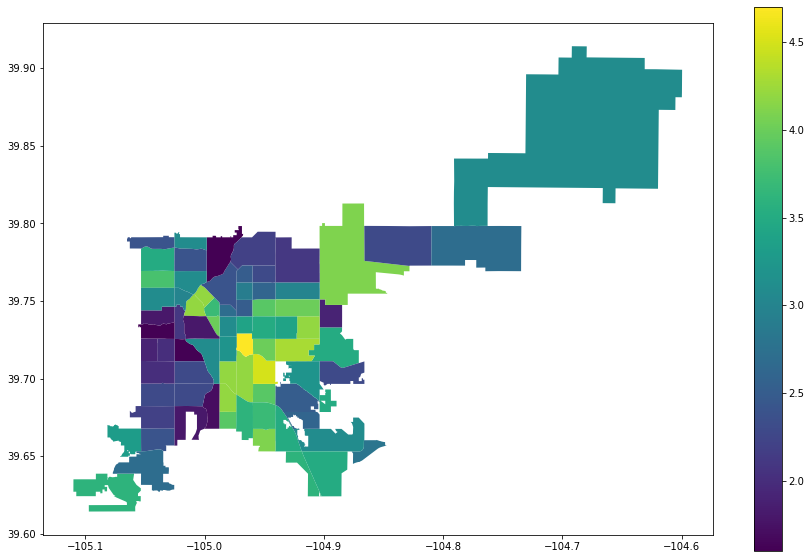

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="OVERALLEQUITY_SCORE", ax=ax, legend=True);

## Merging Pedestrian Demand Data and Equity Index Data

Pedestrian Demand Index Scores (PDI) are available over smaller geographic areas than the Equity Scores, so the average PDI is calculated over a a region with a single equity. When choosing neighborhoods for analysis, we are interested in finding neighborhoods with both a low Equity Score and high PDI scores. Both scores are scaled to be between 0 and 10, and then the absolute difference of the two scores  is calculated.  


We call this score the Pedestrian Equity Difference Score.  

Pedestrian-Equity Difference Score = $$|PDI_{10} - EI_{10}|$$ 
  
Future work may reweight the PDI or Equity Index in a weighted average to assign different, possibly negative weights to the Equity Index or PDI.

Adding column "EQUITY_SCORE_10" to data frame, scaling overall equity score so that its max value is 10.

In [9]:
equity_score_10 = equity_data["OVERALLEQUITY_SCORE"]
equity_score_10 = (equity_score_10 / max(equity_score_10)) * 10
equity_data.insert(7, "EQUITY_SCORE_10", equity_score_10, False)

Merging equity data and pedestrian data. This merge uses predicate "intersects," so some pedestrian data entries may be counted multiple times if they intersect with multiple equity data entries.

In [10]:
equity_ped_data = equity_data.sjoin(pedestrian_data)
equity_ped_data.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,SHAPE_Length_left,SHAPE_Area_left,geometry,index_right,GEOID10,PDI_Score,PDI_Ranking,SHAPE_Length_right,SHAPE_Area_right
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339...",139,0803100411020,3,LOW,0.06106,0.000150
62,Southmoor Park,4.0,4.5,3.0,5.0,1.5,3.6,7.659575,0.107831,0.000253,"MULTIPOLYGON (((-104.90186 39.62409, -104.9040...",139,0803100411020,3,LOW,0.06106,0.000150
63,Hampden South,4.5,4.0,2.5,4.0,2.5,3.5,7.446809,0.120254,0.000791,"MULTIPOLYGON (((-104.90205 39.62443, -104.9023...",139,0803100411020,3,LOW,0.06106,0.000150
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339...",309,0803100411030,7,HIGH,0.05323,0.000083
61,Hampden,3.0,3.0,3.0,4.0,2.5,3.1,6.595745,0.200578,0.000768,"MULTIPOLYGON (((-104.86602 39.66027, -104.8663...",309,0803100411030,7,HIGH,0.05323,0.000083


* Since "pedestrian_data" is spatially subdivided more than "equity_data", the following code finds the average "PDI_Score" for each neighborhood in "equity_data," storing those values in "AVG_PDI_SCORE." 
* It then scales those averages so their max value is 10, storing those values in "AVG_PDI_10." 
* Finally it takes the difference of "AVG_PDI_10" and "EQUITY_SCORE_10" for each neighborhood, and stores those values in "PDI_EQUITY_DIFF." I.e., higher PDI scores and lower equity scores are more desirable, lower PDI scores and higher equity scores are less desirable. 
* Additionally, since PDI and Equity are both scaled to have max values of 10, they are weighed equally in consideration.

In [11]:
nbrhd_count = [0] * len(equity_data)
nbrhd_total = [0] * len(equity_data)

#kind of inefficient, but finding average PDI score for smaller neighborhoods
#in each larger neighborhood
for i in range(len(equity_ped_data)):
  for j in range(len(equity_data)):
    if (equity_ped_data.iat[i,0] == equity_data.iat[j,0]):
      nbrhd_count[j] += 1
      nbrhd_total[j] += equity_ped_data.iat[i,13]

In [12]:
AVG_PDI_SCORE = [0] * len(equity_data)

#storing average PDI score for each neighborhood in equity_data
for i in range(len(equity_data)):
  AVG_PDI_SCORE[i] = nbrhd_total[i] / nbrhd_count[i]

#scaling AVG_PDI_SCORe by 10
AVG_PDI_10 = (AVG_PDI_SCORE / max(AVG_PDI_SCORE)) * 10

#finding difference between pedestrian demand and equity
PDI_EQUITY_DIFF = AVG_PDI_10 - equity_score_10

#adding all three new variables to equity_data
equity_data.insert(8, "AVG_PDI_SCORE", AVG_PDI_SCORE, False)
equity_data.insert(9, "AVG_PDI_10", AVG_PDI_10, False)
equity_data.insert(10, "PDI_EQUITY_DIFF", PDI_EQUITY_DIFF, False)

equity_data.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area,geometry
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,4.428571,4.942169,-2.504639,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339..."
1,Harvey Park,2.0,2.5,2.0,3.0,1.5,2.2,4.680851,3.500000,3.905908,-0.774943,0.105342,0.000458,"MULTIPOLYGON (((-105.02511 39.66772, -105.0260..."
2,Mar Lee,2.0,1.5,2.5,2.0,3.5,2.3,4.893617,4.933333,5.505470,0.611853,0.085462,0.000410,"MULTIPOLYGON (((-105.02506 39.69675, -105.0250..."
3,East Colfax,1.5,1.5,3.5,1.0,2.0,1.9,4.042553,3.083333,3.440919,-0.601634,0.073874,0.000291,"MULTIPOLYGON (((-104.88466 39.74746, -104.8846..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."


Plotting neighborhoods by "PDI_EQUITY_DIFF."

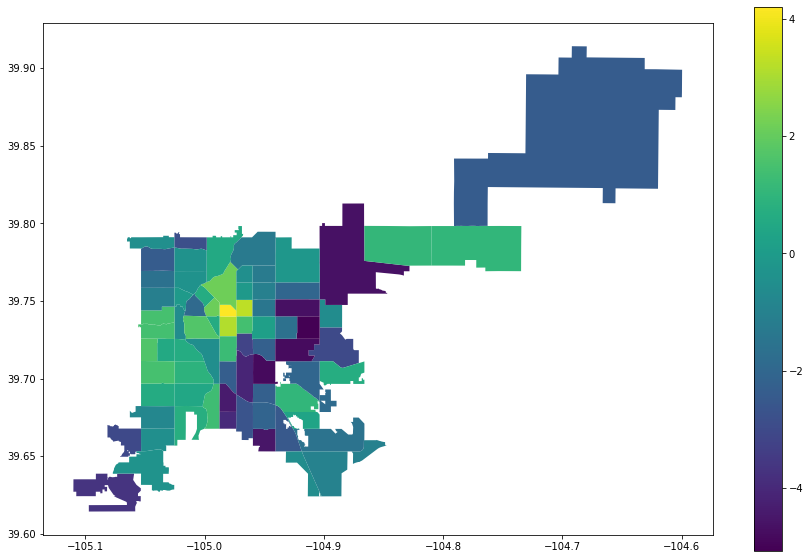

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="PDI_EQUITY_DIFF", ax=ax, legend=True);

The 5 neighborhoods we identified with the Pedestrian-Equity Difference Score are
- North Capitol Hill
- City Park West
- Capitol Hill
- Five Points
- Central Business District


We focus on the North Capitol Hill Neighborhood for the rest of the tutorial.

In [15]:
nbrhds_of_interest = equity_data.sort_values(by = ["PDI_EQUITY_DIFF"], ascending = False)[0:1]
nbrhds_of_interest.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area,geometry
5,North Capitol Hill,3.0,2.0,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096,"MULTIPOLYGON (((-104.97338 39.74378, -104.9733..."


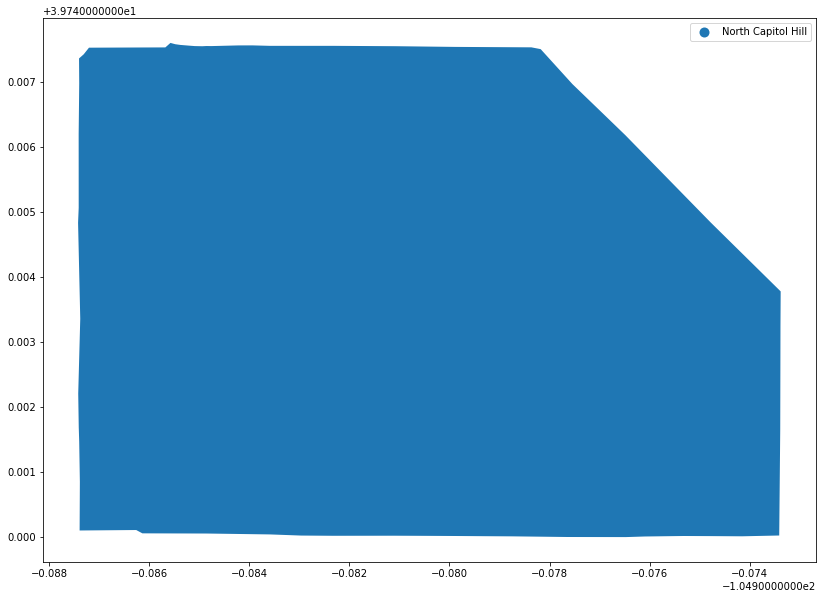

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, legend=True);

# Street Selection

Now that we have identified our candidate neighborhoods, candidate streets for conversion to shared access are identified within these neighborhoods. We pick streets based upon:
- Crash Data
- Key Destination Data
- Transit Stop Data

Neighborhoods and streets with a higher number of car accidents are prioritized for conversion to Shared Street in order to improve pedestrian and biking experience . When considering accident data we created a 400m buffer around crash site data. This allowed us capture areas that have a high concentration of traffic accidents in our analysis.  
The key neighborhood destinations that we considered are schools and parks, prioritizing neighborhoods with more schools and parks . You are welcome to modify or add different key destinations, like restaurants, hospitals or libraries, in your analysis.


## Crash Data  
Storing Crash Data

In [16]:
crash_data = gpd.read_file("../data/traffic_accidents.gdb", driver="OpenFileGDB")
crash_data.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,geometry
0,1.0,2017100002,201710000254410,5441,0,TRAF - ACCIDENT,I70 HWYEB / N NORTHFIELD QUEBEC ST,3167637.0,1708927.0,-104.903568,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.90357 39.77830)
1,2.0,2017100074,201710007454410,5441,0,TRAF - ACCIDENT,3200 N BRIGHTON BLVD,3145663.0,1704934.0,-104.981828,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.98183 39.76771)
2,3.0,2017100083,201710008354410,5441,0,TRAF - ACCIDENT,I70 HWYEB / I270 HWYWB,3174254.0,1708511.0,-104.880037,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.88004 39.77704)
3,4.0,2017100084,201710008454410,5441,0,TRAF - ACCIDENT,W 1ST AVENUE / N VRAIN STREET,NaN,NaN,NaN,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None
4,5.0,2017100117,201710011754010,5401,0,TRAF - ACCIDENT - HIT & RUN,S PLATTE RIVER DR / W TENNESSEE AVE,3142747.0,1679702.0,-104.992702,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.99270 39.69849)


Subsetting crash data by pedestrian-involved, bicyclist-involved, or involving serious injury or death.

In [17]:
crash_data = crash_data[(crash_data["BICYCLE_IND"] > 0) | (crash_data["PEDESTRIAN_IND"] > 0) | (crash_data["SERIOUSLY_INJURED"] > 0) | (crash_data["FATALITIES"] > 0)]
crash_data.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,geometry
44,45.0,2017101418,201710141854411,5441,1,TRAF - ACCIDENT - SBI,2600 BLOCK S MONACO ST,3165327.0,1669042.0,-104.912704,...,OTHER,OTHER,OTHER,1.0,0.0,OTHER,OTHER,PEDESTRIAN,OTHER,POINT (-104.91270 39.66885)
51,52.0,2017102174,201710217454410,5441,0,TRAF - ACCIDENT,3550 S KENDALL ST,3122263.0,1662642.0,-105.065788,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.06579 39.65195)
67,68.0,2017102725,201710272554410,5441,0,TRAF - ACCIDENT,I70 HWYWB / N BRIGHTON BLVD,3149779.0,1709487.0,-104.967092,...,00,NO APPARENT,OTHER,1.0,0.0,OTHER,OTHER,PASSENGER CAR/VAN,OTHER,POINT (-104.96709 39.78014)
75,76.0,2017102901,201710290154411,5441,1,TRAF - ACCIDENT - SBI,4300 BLOCK W FLORIDA AVE,3128406.0,1676323.0,-105.043727,...,OTHER,OTHER,CROSS/ENTER AT INTERSECTION,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.04373 39.68942)
82,83.0,2017103278,201710327854010,5401,0,TRAF - ACCIDENT - HIT & RUN,1600 BLOCK 17TH ST,3140799.0,1699264.0,-104.999242,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.99924 39.75222)


Subsetting "crash_data" by intersecting with "nbrhds_of_interest," which is North Capitol Hill. 

In [18]:
crash_data = crash_data.sjoin(nbrhds_of_interest)
crash_data.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
1920,1921.0,2017173499,201717349954010,5401,0,TRAF - ACCIDENT - HIT & RUN,N LINCOLN ST / E 16TH AVE,3144511.0,1695445.0,-104.986117,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2579,2580.0,2017194401,201719440154010,5401,0,TRAF - ACCIDENT - HIT & RUN,E 16TH AVE / N LOGAN ST,3145575.0,1695450.0,-104.982334,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
3071,3072.0,201721070,20172107054410,5441,0,TRAF - ACCIDENT,PARK AVE / N DOWNING ST,3148087.0,1696230.0,-104.973385,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
4457,4458.0,2017256365,201725636554410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N SHERMAN ST,3144866.0,1695446.0,-104.984855,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
5264,5265.0,2017282407,201728240754410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N PENNSYLVANIA ST,3145925.0,1695452.0,-104.981089,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Plotting crash data within North Capitol Hill

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


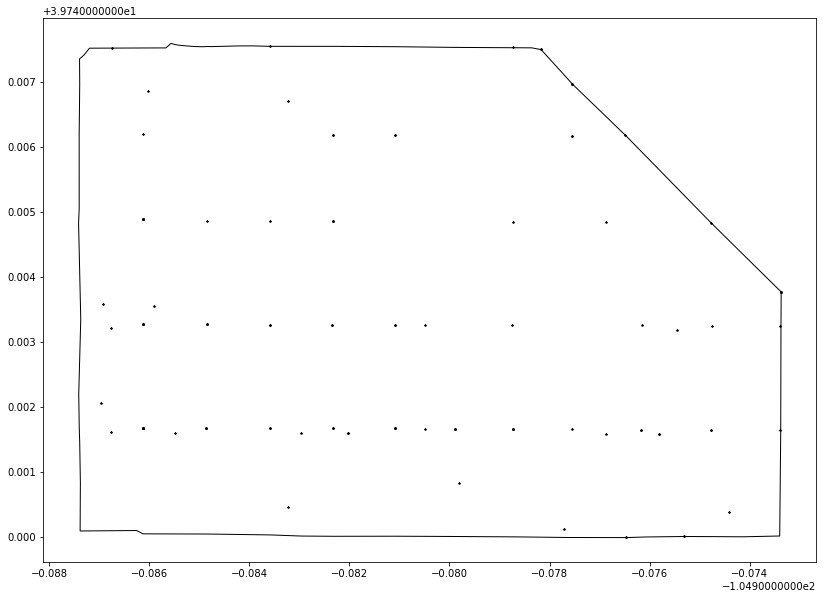

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
crash_data.plot(ax = base, marker = "*", color = "black", markersize = 3);

## Key Destinations  
### Park Data

Storing park data

In [23]:
park_data = gpd.read_file("../data/parks.gdb", driver="OpenFileGDB")
park_data.head()

,LOCATION,FORMAL_NAME,LOC_CODE,PARK_TYPE,PARK_CLASS,GIS_ACRES,DESIGNATED,FIRST_AQ_DATE,MASTER_PLAN,MAINT_DIST,...,LONGITUDE,MARKETING_CODE,FACILITIES,DIAGRAM,PHOTO,PARCEL_MATCH,BND_QC,SHAPE_Length,SHAPE_Area,geometry
0,Verbena,Verbena Park,L18,Park,Neighborhood,7.185635,Yes,1969,None,NE,...,-104.891271,PK,"Picnic Shelter, Picnic Tables, Benches, Playgr...",ParkArt_Verbena Park.pdf,verbenapark.jpg,Yes,2015-09-09T00:00:00+00:00,0.007571,0.000003,"MULTIPOLYGON (((-104.89070 39.73294, -104.8918..."
1,Legault Mountain,Legault Mountain Tracts,M30,Conservation Tract,Mountain,134.790235,Yes,1924,2008,MP,...,-105.245073,None,"Scenic View Shed, Natural Open Space",,no_imagerec.gif,None,2010-05-14T00:00:00+00:00,0.053131,0.000057,"MULTIPOLYGON (((-105.24317 39.53059, -105.2431..."
2,Hobbs Peak,Hobbs Peak Tract,M29,Conservation Tract,Mountain,38.849537,Yes,1925,2008,MP,...,-105.302888,None,"Scenic View Shed, Natural Open Space",,no_imagerec.gif,None,2010-05-21T00:00:00+00:00,0.016372,0.000016,"MULTIPOLYGON (((-105.30059 39.59120, -105.3012..."
3,City of Takayama,City of Takayama Park,331,Park,Linear,6.060320,Yes,1966,None,E,...,-104.943746,PK,"Benches, Bike/Pedestrian Path, Cherry Creek Trail",ParkArt_City of Takayama Park.pdf,takayamapark.jpg,No,2009-09-30T00:00:00+00:00,0.016074,0.000003,"MULTIPOLYGON (((-104.94715 39.71108, -104.9464..."
4,Highline Canal (Parker to Havana),Highline Canal (Parker to Havana),661,Park,Linear,28.792370,Not Eligible,N/A - DW (1980s),N/A,NE,...,-104.884899,None,"Bike/Pedestrian Path, High Line Canal Trail, O...",ParkArt_Highline Canal.pdf,no_imagerec.gif,Yes,2009-06-08T00:00:00+00:00,0.085017,0.000012,"MULTIPOLYGON (((-104.89017 39.70461, -104.8901..."


Subsetting park data by intersecting with neighborhood of interest, North Capitol Hill.

In [24]:
park_data = park_data.sjoin(nbrhds_of_interest)
park_data.head()

,LOCATION,FORMAL_NAME,LOC_CODE,PARK_TYPE,PARK_CLASS,GIS_ACRES,DESIGNATED,FIRST_AQ_DATE,MASTER_PLAN,MAINT_DIST,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length_right,SHAPE_Area_right
196,Park Ave Parks,Park Ave Parks,317,Park,Neighborhood,2.724734,Yes - 1956,1874,None,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Plotting parks within North Capitol Hill.

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


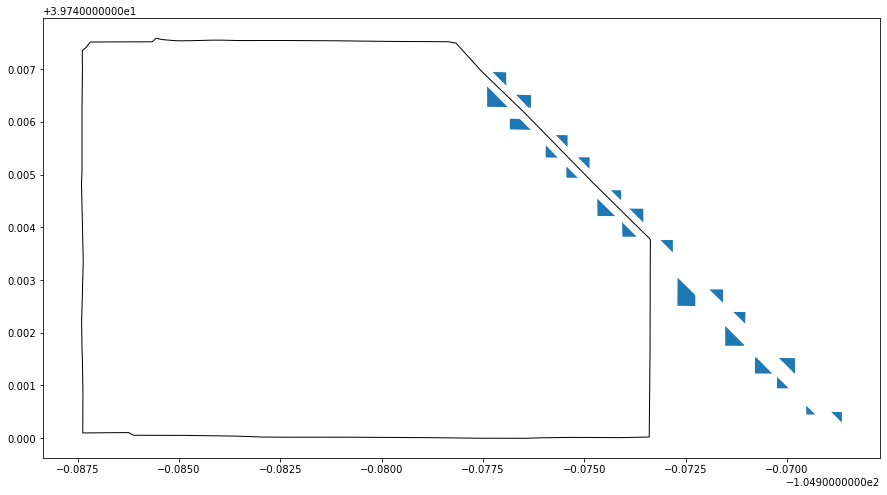

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
park_data.plot(ax = base);

## School Data

Storing school data.

In [26]:
school_data = gpd.read_file("../data/schools/school_point.shp")
school_data.head()

,amenity,name,ele,addr_house,addr_postc,addr_stree,addr_city,addr_state,phone,website,wikidata,old_name,alt_name,addr_unit,addr_hou_1,email,fax,operator,opening_ho,geometry
0,school,Abraham Lincoln High School,1648,None,None,None,None,None,None,None,Q4669022,None,None,None,None,None,None,None,None,POINT (-105.02693 39.67665)
1,school,Academia Ana Marie Sandoval,1617,3655,80211,Wyandot Street,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.01543 39.76713)
2,school,Academy of Urban Learning High School,None,2417,80211,West 29th Avenue,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.01689 39.75869)
3,school,Ace Community Challenge Charter School,1598,948,80204,Santa Fe Drive,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-104.99849 39.73150)
4,school,All Saints School,1649,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.02637 39.67193)


Subsetting schools data by intersecting with neighborhoods of interest.

In [27]:
school_data = school_data.sjoin(nbrhds_of_interest)
school_data.head()

,amenity,name,ele,addr_house,addr_postc,addr_stree,addr_city,addr_state,phone,website,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
50,school,Emily Griffith High School,None,1860,80203,Lincoln Street,Denver,CO,None,None,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Plotting schools within North Capitol Hill.

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


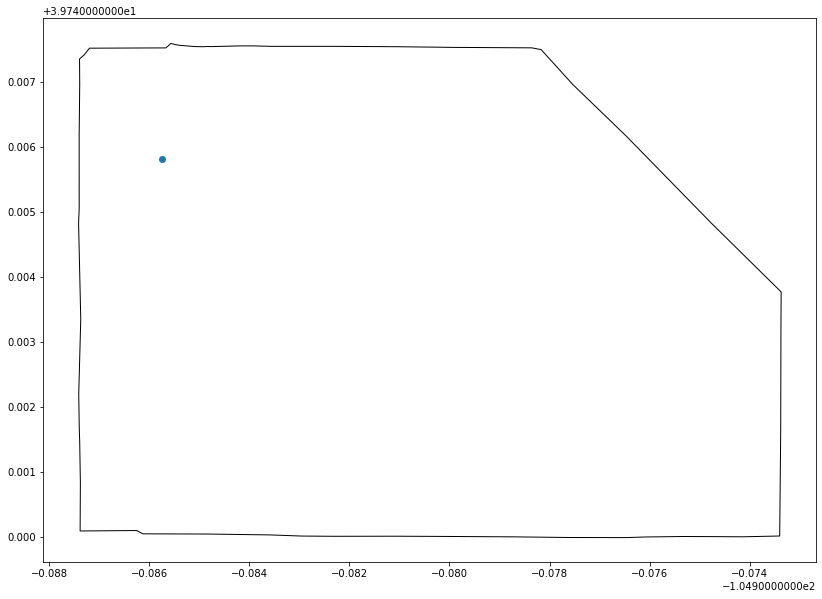

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
school_data.plot(ax = base);

## Transit Stops  
### Bus Stop Data  
Storing bus stop data.

In [29]:
bus_data = gpd.read_file("../data/busstops/RTD_GIS_Current_Runboard.shp")
bus_data.head()

,OBJECTID,BSID,LNG,LAT,X_COORD,Y_COORD,STATUS,ROUTES,STOPNAME,DIR,...,COMMENTS,ON_STREET,AT_STREET,BETWEEN__1,STATION_ID,HUBABBR,HUBNAME,SBOARDS,STOPNAME_B,geometry
0,3367927,13768,-105.025279,39.729654,3.133521e+06,1.691005e+06,active,"31, 30",Federal Blvd & W 8th Ave,S,...,AUG 2019,Federal Blvd,W 8th Av,None,NaN,None,None,0,Federal Blvd & W 8th Ave (Stop No. 13768),POINT (-105.02529 39.72966)
1,3367928,23955,-104.994238,39.759506,3.142191e+06,1.701926e+06,active,"120X, 38, LX, FF, LD",Park Ave West & Wewatta St,SE,...,DELGANY RAMP,Park Ave West,Wewatta St,None,NaN,None,None,0,Park Ave West & Wewatta St (Stop No. 23955),POINT (-104.99425 39.75951)
2,3367929,17398,-104.959690,39.759724,3.151904e+06,1.702061e+06,active,24,York St & 30th Ave,N,...,None,York St,E 30th Ave,None,NaN,None,None,0,York St & 30th Ave (Stop No. 17398),POINT (-104.95970 39.75973)
3,3367930,11069,-104.975069,39.772599,3.147553e+06,1.706726e+06,active,12,38th St & Brighton Blvd,SE,...,None,38th St,Brighton Blvd,None,NaN,None,None,0,38th St & Brighton Blvd (Stop No. 11069),POINT (-104.97508 39.77261)
4,3367931,11084,-105.115058,39.718918,3.108286e+06,1.686975e+06,active,GS,3rd St & Main Ave {1304},NW,...,None,3rd St,W Main Ave,None,NaN,None,None,0,3rd St & Main Ave {1304} (Stop No. 11084),POINT (-105.11507 39.71892)


Subsetting bus stop data within neighborhoods of interest.

In [30]:
bus_data = bus_data.sjoin(nbrhds_of_interest)
bus_data.head()

,OBJECTID,BSID,LNG,LAT,X_COORD,Y_COORD,STATUS,ROUTES,STOPNAME,DIR,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
118,3368045,10280,-104.977204,39.743193,3.147014e+06,1.696011e+06,active,20,17th Ave & Clarkson St,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
260,3368187,12952,-104.980868,39.740096,3.145990e+06,1.694877e+06,active,15,Colfax Ave & Pennsylvania St,W,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
557,3368484,10345,-104.979029,39.744910,3.146498e+06,1.696633e+06,active,20,18th Ave & Washington St,W,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
815,3368742,10359,-104.980028,39.746135,3.146214e+06,1.697078e+06,active,"28, 32",19th Ave & Pearl St,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
838,3368765,35033,-104.986429,39.740952,3.144425e+06,1.695180e+06,active,"48, 99L, 19, 32",Civic Center Station Gate 3,N,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Plotting bus stops within neighborhoods of interest.

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


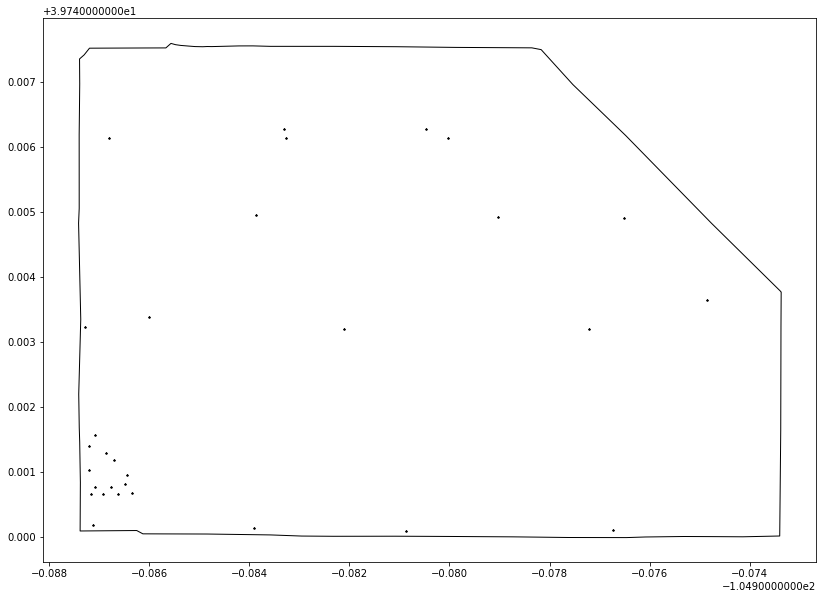

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
bus_data.plot(ax = base, marker = "*", color = "black", markersize = 3);

### Lightrail Stop Data  
Storing lightrail stop data.

In [33]:
lightrail_data = gpd.read_file("../data/lightrailstations/RTD_GIS_Current_Runboard.shp")
lightrail_data.head()

,OBJECTID,PID,NAME,LOCAL_RTS,EXPRESS_RT,LIMITED_RT,REGIONAL_R,SKYRIDE_RT,SPECIAL_RT,ADDRESS,...,ZIPCODE,PARCEL_ID_,DIAGRAM,LOCATION,RAIL_LINE,STOPID,VMAP,CNRS,INFO_REPOR,geometry
0,80,64,Littleton / Mineral Station,402L,None,None,None,None,D,3203 W Mineral Ave,...,80120,Stop#: 24896,BroncosRide,S Santa Fe & Mineral Ave,D,33716,South Jeffco,SJFX,None,POINT (-105.02503 39.58009)
1,81,63,Littleton / Downtown Station,29-36-59-66,None,None,None,None,D,5777 S Prince St,...,80120,Stop#: 25438 (South)<br />Stop#: 24894 (North),BroncosRide,SE Corner of Alamo & Prince St,D,33715,South Jeffco,SJFX,"261 spots at station, 100 spots at S. Powers o...",POINT (-105.01488 39.61197)
2,82,65,Oxford-City of Sheridan Station,51,None,None,None,None,D,4101 Windermere St,...,80110,Stop#: 25437 (South)<br />Stop#: 24892 (North),BroncosRide,Santa Fe & Oxford,D,33726,None,None,None,POINT (-105.00482 39.64290)
3,83,1,Alameda Station,1-3-4-52,None,None,None,None,D-E-H,499 S Cherokee St,...,80223,Stop#: 23060 (South)<br />Stop#: 23042 (North),BroncosRide,Cherokee St & Alaska Pl,D-E-H,33704,Platte Valley,PLFX,None,POINT (-104.99317 39.70868)
4,84,71,18th St / California Station,None,None,None,None,None,D-H-L,1776 California St,...,80202,Stop#: 23047,None,18th St & California,D-H-L,34116,None,None,None,POINT (-104.99029 39.74660)


Subsetting lightrail stops within neighborhood of interest, North Capitol Hill.

In [34]:
lightrail_data = lightrail_data.sjoin(nbrhds_of_interest)
lightrail_data.head()

,OBJECTID,PID,NAME,LOCAL_RTS,EXPRESS_RT,LIMITED_RT,REGIONAL_R,SKYRIDE_RT,SPECIAL_RT,ADDRESS,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area


There are no lightrail stations in North Capitol Hill, so we do not consider lightrail stations when proposing candidate streets.

## Street Data  
Storing North Capitol Hill Street Data 

In [35]:
street_data = ox.graph.graph_from_polygon(unary_union(nbrhds_of_interest.geometry.values), network_type="drive")

Plotting streets within North Capitol Hill  with key destinations and crashes.

NameError: name 'line' is not defined

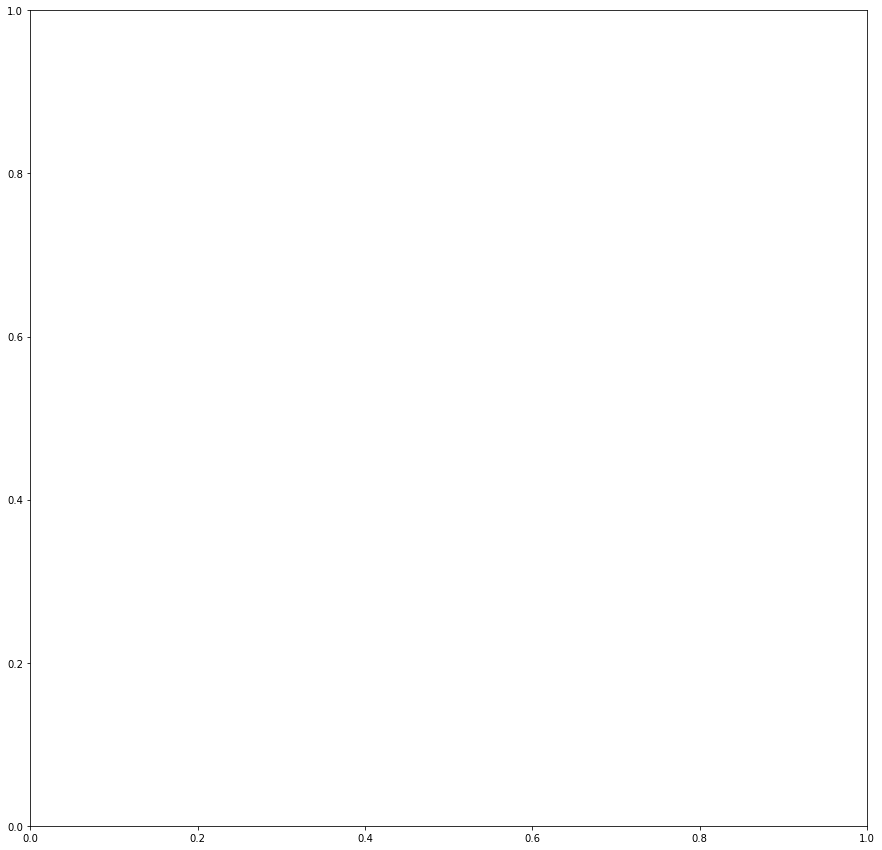

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

legend = [line.Line2D([0],[0],marker='o',color='w',label='Crash', markerfacecolor='red', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Bus Stop', markerfacecolor='blue', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Lightrail Stop', markerfacecolor='green', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Park', markerfacecolor='orange', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='School', markerfacecolor='purple', markersize=10)]
ax.legend(handles=legend)

fig, base = ox.plot_graph(street_data, node_alpha=0, show=False, bgcolor="none", ax=ax)
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=base, alpha=0.1, edgecolor="black", linewidth=1.5)
crash_data.plot(ax = base, marker = "o", color = "red", markersize = 15)
bus_data.plot(ax = base, marker = "o", color = "blue", markersize = 15)
lightrail_data.plot(ax = base, marker = "o", color = "green", markersize = 50)
park_data.plot(ax = base, color = "orange")
school_data.plot(ax = base, color = "purple", markersize = 50);

Creating buffers around the streets

In [37]:
street_buffers = ox.utils_graph.graph_to_gdfs(street_data, edges=True, nodes=False)\
    .to_crs(epsg=util.CONFIG.local_crs)
street_buffers["geometry"] = street_buffers["geometry"].buffer(400)
street_buffers = street_buffers.to_crs(epsg=util.CONFIG.base_crs)
street_buffers.head()

osmid  oneway lanes  \
u         v          key                                                    
176071275 3376084229 0                            330615235    True     2   
176071277 3376084228 0                             16982257   False     2   
          176071279  0                            124661412   False     2   
          176080651  0    [628398051, 628398052, 944148645]    True     4   
176071279 176071280  0                            124661412   False     2   

                                      name   highway   length  \
u         v          key                                        
176071275 3376084229 0    East 16th Avenue  tertiary   41.152   
176071277 3376084228 0    East 16th Avenue  tertiary   11.201   
          176071279  0    East 16th Avenue  tertiary  107.751   
          176080651  0      Lincoln Street   primary  176.779   
176071279 176071280  0    East 16th Avenue  tertiary  108.272   

                                                                   geometry  \
u         v          key                                                      
176071275 3376084229 0    POLYGON ((-104.98725 39.74529, -104.98690 39.7...   
176071277 3376084228 0    POLYGON ((-104.98628 39.73808, -104.98673 39.7...   
          176071279  0    POLYGON ((-104.98598 39.74528, -104.98549 39.7...   
          176080651  0    POLYGON ((-104.99078 39.74178, -104.99078 39.7...   
176071279 176071280  0    POLYGON ((-104.98473 39.74528, -104.98422 39.7...   

                         maxspeed  ref  
u         v          key                
176071275 3376084229 0        NaN  NaN  
176071277 3376084228 0        NaN  NaN  
          176071279  0        NaN  NaN  
          176080651  0     30 mph  NaN  
176071279 176071280  0        NaN  NaN

Plotting streets with buffers

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


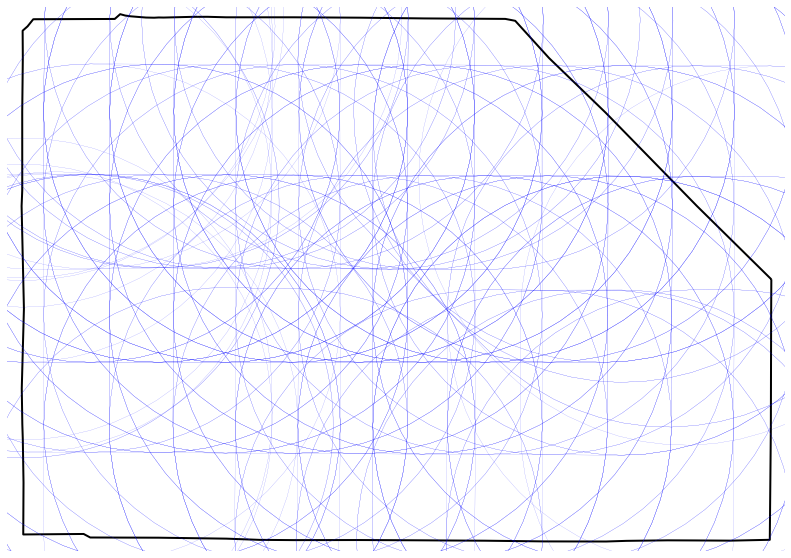

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
fig, base = ox.plot_graph(street_data, node_alpha=0, show=False, bgcolor="white", ax=ax)
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=base, color="white", edgecolor="black", linewidth=2)
#street_data.plot(ax = base, color = "black", linewidth = 1)
street_buffers.plot(ax = base, color = "none", edgecolor = "blue", linewidth = 0.1);

## Crashes and Key Destinations near Streets  
Removing "index_right" columns from each data set so they can be merged again.

In [39]:
street_edges = ox.utils_graph.graph_to_gdfs(street_data, edges=True, nodes=False)

In [40]:
crash_data = crash_data.drop(["index_right"], axis = 1)
park_data = park_data.drop(["index_right"], axis = 1)
school_data = school_data.drop(["index_right"], axis = 1)
bus_data = bus_data.drop(["index_right"], axis = 1)
lightrail_data = lightrail_data.drop(["index_right"], axis = 1)
#street_buffers = street_buffers.drop(["index_right"], axis = 1)
#street_data = street_data.drop(["index_right"], axis = 1)

In [41]:
nch_streets = street_edges.sjoin(nbrhds_of_interest.iloc[[0]])
nch_streets.head()

osmid  oneway lanes  \
u         v          key                                                    
176071275 3376084229 0                            330615235    True     2   
176071277 3376084228 0                             16982257   False     2   
          176071279  0                            124661412   False     2   
          176080651  0    [628398051, 628398052, 944148645]    True     4   
176071279 176071280  0                            124661412   False     2   

                                      name   highway   length  \
u         v          key                                        
176071275 3376084229 0    East 16th Avenue  tertiary   41.152   
176071277 3376084228 0    East 16th Avenue  tertiary   11.201   
          176071279  0    East 16th Avenue  tertiary  107.751   
          176080651  0      Lincoln Street   primary  176.779   
176071279 176071280  0    East 16th Avenue  tertiary  108.272   

                                                                   geometry  \
u         v          key                                                      
176071275 3376084229 0    LINESTRING (-104.98739 39.74169, -104.98726 39...   
176071277 3376084228 0    LINESTRING (-104.98611 39.74168, -104.98624 39...   
          176071279  0    LINESTRING (-104.98611 39.74168, -104.98599 39...   
          176080651  0    LINESTRING (-104.98611 39.74168, -104.98611 39...   
176071279 176071280  0    LINESTRING (-104.98485 39.74168, -104.98474 39...   

                         maxspeed  ref  index_right  ... MORBIDITY_SCORE  \
u         v          key                             ...                   
176071275 3376084229 0        NaN  NaN            5  ...             2.5   
176071277 3376084228 0        NaN  NaN            5  ...             2.5   
          176071279  0        NaN  NaN            5  ...             2.5   
          176080651  0     30 mph  NaN            5  ...             2.5   
176071279 176071280  0        NaN  NaN            5  ...             2.5   

                          MORTALITY_SCORE  BUILTENV_SCORE  \
u         v          key                                    
176071275 3376084229 0                1.0             5.0   
176071277 3376084228 0                1.0             5.0   
          176071279  0                1.0             5.0   
          176080651  0                1.0             5.0   
176071279 176071280  0                1.0             5.0   

                          OVERALLEQUITY_SCORE  EQUITY_SCORE_10  AVG_PDI_SCORE  \
u         v          key                                                        
176071275 3376084229 0                    2.7         5.744681       8.916667   
176071277 3376084228 0                    2.7         5.744681       8.916667   
          176071279  0                    2.7         5.744681       8.916667   
          176080651  0                    2.7         5.744681       8.916667   
176071279 176071280  0                    2.7         5.744681       8.916667   

                          AVG_PDI_10  PDI_EQUITY_DIFF  SHAPE_Length  \
u         v          key                                              
176071275 3376084229 0      9.950766         4.206085      0.040371   
176071277 3376084228 0      9.950766         4.206085      0.040371   
          176071279  0      9.950766         4.206085      0.040371   
          176080651  0      9.950766         4.206085      0.040371   
176071279 176071280  0      9.950766         4.206085      0.040371   

                          SHAPE_Area  
u         v          key              
176071275 3376084229 0      0.000096  
176071277 3376084228 0      0.000096  
          176071279  0      0.000096  
          176080651  0      0.000096  
176071279 176071280  0      0.000096  

[5 rows x 23 columns]

Subsetting crashes within NCH.

In [42]:
nch_streets = street_edges.sjoin(nbrhds_of_interest.iloc[[0]])
nch_streets.head()

osmid  oneway lanes  \
u         v          key                                                    
176071275 3376084229 0                            330615235    True     2   
176071277 3376084228 0                             16982257   False     2   
          176071279  0                            124661412   False     2   
          176080651  0    [628398051, 628398052, 944148645]    True     4   
176071279 176071280  0                            124661412   False     2   

                                      name   highway   length  \
u         v          key                                        
176071275 3376084229 0    East 16th Avenue  tertiary   41.152   
176071277 3376084228 0    East 16th Avenue  tertiary   11.201   
          176071279  0    East 16th Avenue  tertiary  107.751   
          176080651  0      Lincoln Street   primary  176.779   
176071279 176071280  0    East 16th Avenue  tertiary  108.272   

                                                                   geometry  \
u         v          key                                                      
176071275 3376084229 0    LINESTRING (-104.98739 39.74169, -104.98726 39...   
176071277 3376084228 0    LINESTRING (-104.98611 39.74168, -104.98624 39...   
          176071279  0    LINESTRING (-104.98611 39.74168, -104.98599 39...   
          176080651  0    LINESTRING (-104.98611 39.74168, -104.98611 39...   
176071279 176071280  0    LINESTRING (-104.98485 39.74168, -104.98474 39...   

                         maxspeed  ref  index_right  ... MORBIDITY_SCORE  \
u         v          key                             ...                   
176071275 3376084229 0        NaN  NaN            5  ...             2.5   
176071277 3376084228 0        NaN  NaN            5  ...             2.5   
          176071279  0        NaN  NaN            5  ...             2.5   
          176080651  0     30 mph  NaN            5  ...             2.5   
176071279 176071280  0        NaN  NaN            5  ...             2.5   

                          MORTALITY_SCORE  BUILTENV_SCORE  \
u         v          key                                    
176071275 3376084229 0                1.0             5.0   
176071277 3376084228 0                1.0             5.0   
          176071279  0                1.0             5.0   
          176080651  0                1.0             5.0   
176071279 176071280  0                1.0             5.0   

                          OVERALLEQUITY_SCORE  EQUITY_SCORE_10  AVG_PDI_SCORE  \
u         v          key                                                        
176071275 3376084229 0                    2.7         5.744681       8.916667   
176071277 3376084228 0                    2.7         5.744681       8.916667   
          176071279  0                    2.7         5.744681       8.916667   
          176080651  0                    2.7         5.744681       8.916667   
176071279 176071280  0                    2.7         5.744681       8.916667   

                          AVG_PDI_10  PDI_EQUITY_DIFF  SHAPE_Length  \
u         v          key                                              
176071275 3376084229 0      9.950766         4.206085      0.040371   
176071277 3376084228 0      9.950766         4.206085      0.040371   
          176071279  0      9.950766         4.206085      0.040371   
          176080651  0      9.950766         4.206085      0.040371   
176071279 176071280  0      9.950766         4.206085      0.040371   

                          SHAPE_Area  
u         v          key              
176071275 3376084229 0      0.000096  
176071277 3376084228 0      0.000096  
          176071279  0      0.000096  
          176080651  0      0.000096  
176071279 176071280  0      0.000096  

[5 rows x 23 columns]

Creating 1/4 mile buffers around nch_streets.

In [43]:
nch_buffers = nch_streets.to_crs(epsg=util.CONFIG.local_crs)
nch_buffers["geometry"] = nch_buffers["geometry"].buffer(400)
nch_buffers = nch_buffers.to_crs(epsg=util.CONFIG.base_crs)

Subsetting crashes within NCH.

In [44]:
nch_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_crashes.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length_right,SHAPE_Area_right
1920,1921.0,2017173499,201717349954010,5401,0,TRAF - ACCIDENT - HIT & RUN,N LINCOLN ST / E 16TH AVE,3144511.0,1695445.0,-104.986117,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2579,2580.0,2017194401,201719440154010,5401,0,TRAF - ACCIDENT - HIT & RUN,E 16TH AVE / N LOGAN ST,3145575.0,1695450.0,-104.982334,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
3071,3072.0,201721070,20172107054410,5441,0,TRAF - ACCIDENT,PARK AVE / N DOWNING ST,3148087.0,1696230.0,-104.973385,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
4457,4458.0,2017256365,201725636554410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N SHERMAN ST,3144866.0,1695446.0,-104.984855,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
5264,5265.0,2017282407,201728240754410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N PENNSYLVANIA ST,3145925.0,1695452.0,-104.981089,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Calculating the percentage of crashes within each street buffer in NCH.

In [45]:
nch_crashes = nch_crashes.drop(["index_right"], axis = 1)
nch_buffers = nch_buffers.drop(["index_right"], axis = 1)

nch_street_crashes = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_crashes.sjoin(nch_buffers.iloc[[i]])
  nch_street_crashes[i] = len(newdat) / len(nch_crashes);

Subsetting all Key Destination data within NCH.

In [46]:
#subsetting data
nch_parks = park_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_schools = school_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[0]])

Calculating the percentage of parks within each street buffer in NCH.

In [47]:
nch_parks = nch_parks.drop(["index_right"], axis = 1)

nch_street_parks = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_parks.sjoin(nch_buffers.iloc[[i]])
  nch_street_parks[i] = len(newdat) / len(nch_parks);

Calculating the percentage of schools within each street buffer in NCH.

In [48]:
nch_schools = nch_schools.drop(["index_right"], axis = 1)

nch_street_schools = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_schools.sjoin(nch_buffers.iloc[[i]])
  nch_street_schools[i] = len(newdat) / len(nch_schools);

Calculating the percentage of bus stops within each street buffer in NCH.

In [49]:
nch_bus_stops = nch_bus_stops.drop(["index_right"], axis = 1)

nch_street_bus_stops = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_bus_stops.sjoin(nch_buffers.iloc[[i]])
  nch_street_bus_stops[i] = len(newdat) / len(nch_bus_stops);

There are no lightrail stops in NCH, so that will not be calculated.

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "nch_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [50]:
def topk(df, by, k):
    seen_idx = set()
    idxs = []
    for idx, row in df.sort_values(by = [by], ascending = False).iterrows():
        if idx not in seen_idx and (idx[1], idx[0], idx[2]) not in seen_idx:
            idxs.append(idx)
            seen_idx.add(idx)
            
        if len(idxs) >= k:
            break
            
    return df.loc[idxs]

In [51]:
nch_events = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  nch_events[i] = nch_street_crashes[i] + nch_street_parks[i] + nch_street_schools[i] + nch_street_bus_stops[i]

nch_streets.insert(1, "NCH_EVENTS", nch_events, False)

best_nch_streets = topk(nch_streets, "NCH_EVENTS", 5)

Printing names of best NCH streets.

In [52]:
for i in range(len(best_nch_streets)):
  print("Street", i+1)
  print(best_nch_streets.name.iloc[i]) #, "from", best_nch_streets.FROMNAME.iloc[i], "to", best_nch_streets.TONAME.iloc[i])

Street 1
East 18th Avenue
Street 2
Pennsylvania Street
Street 3
East 19th Avenue
Street 4
East 19th Avenue
Street 5
Pennsylvania Street


Plotting best streets in NCH neighborhood.

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


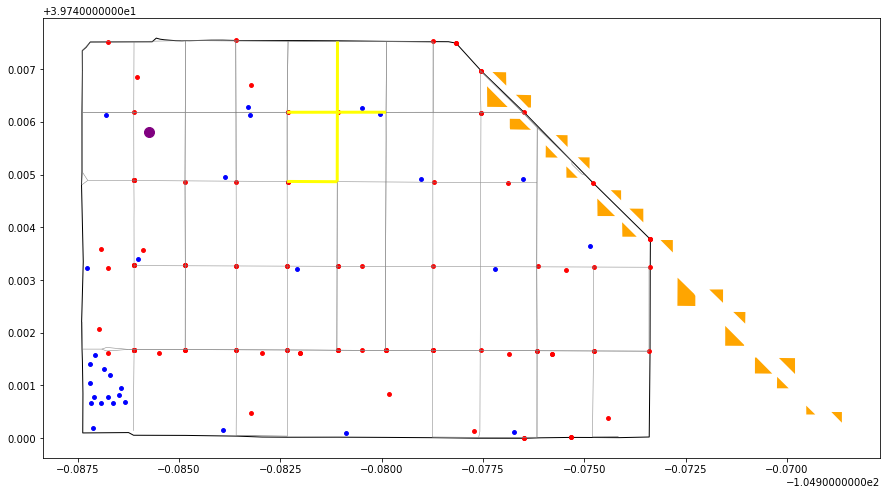

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[0]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
nch_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_nch_streets.plot(ax = base, color = "yellow", linewidth = 3)
nch_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
nch_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
nch_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
nch_parks.plot(ax = base, color = "orange")
nch_schools.plot(ax = base, color = "purple", markersize = 100);

## 5 Candidate Streets

The 5 streets identified in the North Capitol Hill Neighborhood were:  
Street 1  
East 18th Avenue  
Street 2  
Pennsylvania Street  
Street 3  
East 19th Avenue  
Street 4  
East 19th Avenue  
Street 5  
Pennsylvania Street  

### Finding Optimal Shared Streets


Now that we have identified candidate streets in the North Capitol Hill Neighborhood, we pass these streets to the All-Pairs Max-Flow Algorithm. Our version of the Max-Flow Algorithm considers a pair of nodes on the boundary of the neighborhood of interest, North Capitol Hill, and calulates how traffic flowing from node to node is affected when candidate streets are removed from the neighborhood whenconverted to shared or open access. The All-Pairs Max-Flow Algorithm performs this for all pairs of nodes on the boundary of the neighborhood. The results across all nodes are averaged for each candidate street, which provides us with a traffic impact score for each candidate street.

## Data Sources  
OSMNX & Open Streets (“© OpenStreetMap contributors” via the Open Database License)  
City of Denver Open Data Catalog (CC BY 3.0)  
### Load Denver Street Data

In [54]:
denver = ox.graph_from_place("Denver, Colorado, USA", network_type="drive")

### Add data to graphs  
Here we add speed limit and capacity limits to the streets in the network using a utility function that we developed based on the paper"". The authors in this paper developed a method for determining maximum safe hourly carrying capacity of a road based on the speed limit and average length of cars on the road. Assumptions were made as to the length of the cars on the road.


In [55]:
denver = util.add_speeds_to_graph(denver)
denver = util.drive_network_to_capacitated_network(denver)

In [56]:
neighborhoods = gpd.read_file(
    "../data/statistical_neighborhoods.gdb", driver="OpenFileGDB"
)

neighborhoods_of_focus = [
    "North Capitol Hill"
]

In [57]:
focus_poly = unary_union(neighborhoods[neighborhoods["NBHD_NAME"].isin(neighborhoods_of_focus)].geometry.values)
focus_network = ox.truncate.truncate_graph_polygon(denver, focus_poly)

## Load up candidate streets
Here we load the candidate streets in North Cap. Hill identified in the previous section of the tutorial.

In [58]:
candidate_streets = gpd.read_file("../processed/candidate_streets.shp")\
    .set_crs(epsg=util.CONFIG.base_crs)\
    .set_index(["u", "v", "key"])
candidate_streets.head()

NCH_EVENTS      highway  oneway   length maxspeed  \
u         v          key                                                      
176086235 4955447713 0      2.898148    secondary       1  105.643   30 mph   
          176086237  0      2.725926  residential       0  146.534     None   
176097378 176086237  0      2.637037     tertiary       0  105.853     None   
176095479 176086237  0      2.535185     tertiary       0  102.724     None   
176086237 176086239  0      2.501852  residential       0  149.367     None   

                           ref access bridge tunnel  index_righ  ...  \
u         v          key                                         ...   
176086235 4955447713 0    None   None   None   None           5  ...   
          176086237  0    None   None   None   None           5  ...   
176097378 176086237  0    None   None   None   None           5  ...   
176095479 176086237  0    None   None   None   None           5  ...   
176086237 176086239  0    None   None   None   None           5  ...   

                         AVG_PDI_SC  AVG_PDI_10  PDI_EQUITY  SHAPE_Leng  \
u         v          key                                                  
176086235 4955447713 0     8.916667    9.950766    4.206085    0.040371   
          176086237  0     8.916667    9.950766    4.206085    0.040371   
176097378 176086237  0     8.916667    9.950766    4.206085    0.040371   
176095479 176086237  0     8.916667    9.950766    4.206085    0.040371   
176086237 176086239  0     8.916667    9.950766    4.206085    0.040371   

                          SHAPE_Area  CPW_EVENTS  CH_EVENTS  FP_EVENTS  \
u         v          key                                                 
176086235 4955447713 0      0.000096         NaN        NaN        NaN   
          176086237  0      0.000096         NaN        NaN        NaN   
176097378 176086237  0      0.000096         NaN        NaN        NaN   
176095479 176086237  0      0.000096         NaN        NaN        NaN   
176086237 176086239  0      0.000096         NaN        NaN        NaN   

                          CBD_EVENTS  \
u         v          key               
176086235 4955447713 0           NaN   
          176086237  0           NaN   
176097378 176086237  0           NaN   
176095479 176086237  0           NaN   
176086237 176086239  0           NaN   

                                                                   geometry  
u         v          key                                                     
176086235 4955447713 0    LINESTRING (-104.98110 39.74486, -104.98122 39...  
          176086237  0    LINESTRING (-104.98110 39.74486, -104.98110 39...  
176097378 176086237  0    LINESTRING (-104.98233 39.74618, -104.98222 39...  
176095479 176086237  0    LINESTRING (-104.97989 39.74618, -104.98000 39...  
176086237 176086239  0    LINESTRING (-104.98109 39.74618, -104.98109 39...  

[5 rows x 28 columns]

## Plot candidate streets

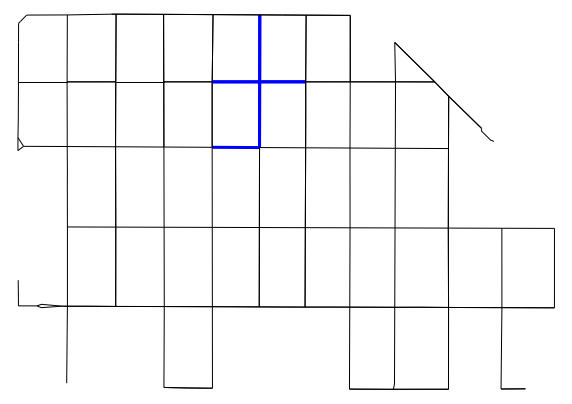

In [59]:
ec_candidate = ['blue' if (edge in candidate_streets.index or (edge[1], edge[0], edge[2]) in candidate_streets.index) else 'black' for edge in focus_network.edges]
lw_candidate = [3 if (edge in candidate_streets.index or (edge[1], edge[0], edge[2]) in candidate_streets.index) else 1 for edge in focus_network.edges]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig, ax = ox.plot_graph(focus_network, node_size=1, edge_color=ec_candidate, node_alpha=0, edge_linewidth=lw_candidate, ax=ax, show=False)

## All Pairs Max-Flow Analysis to Determine Streets with Least Impact on Traffic Flow

Running the All-Pairs Max-Flow algorithm to determine which of the candidate streets have to most impact on traffic flow under removal, and plotting the results.

In [60]:
def removal_impact(
    network: nx.DiGraph,
    arc: (int, int, int),
    radius: float, 
) -> float:
    
    net = nx.DiGraph(network)
    edges = ox.utils_graph.graph_to_gdfs(network, edges=True, nodes=False)
    area_of_interest = edges.loc[[arc]].to_crs(epsg=util.CONFIG.local_crs) \
        .geometry.representative_point().buffer(radius) \
        .to_crs(epsg=util.CONFIG.base_crs).iloc[0]
    
    net = nx.DiGraph(ox.truncate.truncate_graph_polygon(net, area_of_interest))
    
    unperturbed_flow_values, _unperturbed_flows = util.all_pairs_max_flow(net, net.nodes)
    net.get_edge_data(arc[0], arc[1])["capacity"] = 0
    if (arc[1], arc[0]) in net.edges:
        net.get_edge_data(arc[1], arc[0])["capacity"] = 0
    
    perturbed_flow_values, _perturbed_flows = util.all_pairs_max_flow(net, net.nodes)
    return {x: perturbed_flow_values[x] - unperturbed_flow_values[x] for x in perturbed_flow_values.keys()}

In [61]:
impacts = {}

for candidate in candidate_streets.index:
    impacts[candidate] = removal_impact(focus_network, candidate, 1000)

All pairs Max Flow: 357it [00:16, 21.22it/s]                                                                           
All pairs Max Flow: 357it [00:21, 16.83it/s]                                                                           
All pairs Max Flow: 357it [00:19, 18.56it/s]                                                                           
All pairs Max Flow: 357it [00:17, 20.89it/s]                                                                           
All pairs Max Flow: 357it [00:16, 22.19it/s]                                                                           
All pairs Max Flow: 357it [00:18, 19.62it/s]                                                                           
All pairs Max Flow: 357it [00:19, 18.72it/s]                                                                           
All pairs Max Flow: 357it [00:17, 20.03it/s]                                                                           
All pairs Max Flow: 357it [00:16, 21.64i

KeyError: "None of [MultiIndex([(2841044065, 3358646006, 0)],\n           names=['u', 'v', 'key'])] are in the [index]"

Calculating the mean impact on traffic flow for each candidate street across all nodes, and plotting these results. 

In [62]:
mean_impacts = {k: np.mean(list(v.values())) for (k, v) in impacts.items()}

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


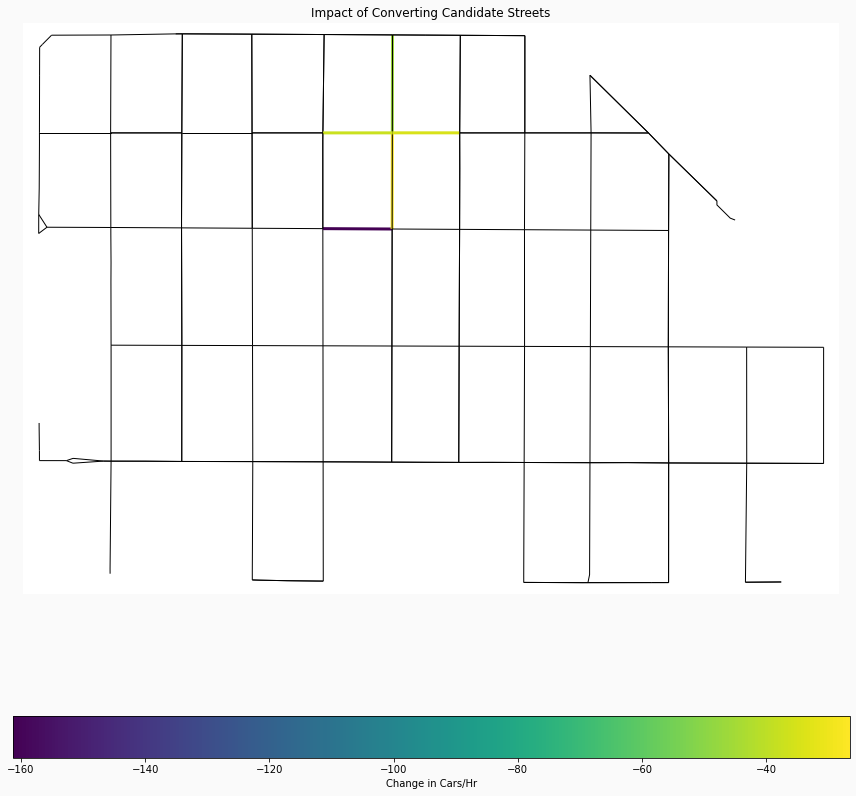

In [63]:
impact_norm = colors.Normalize()
impact_norm.autoscale(list(mean_impacts.values()))

ec_impacts = [cm.viridis(impact_norm(mean_impacts[edge])) if edge in mean_impacts else 'black' for edge in focus_network.edges]
lw_candidate = [3 if edge in candidate_streets.index else 1 for edge in focus_network.edges]
fig, ax = plt.subplots(1, 1, figsize=(15, 15), facecolor='#fafafa')
ox.plot_graph(focus_network, node_size=1, edge_color=ec_impacts, node_alpha=0, bgcolor="#fafafa", edge_linewidth=lw_candidate, show=False, ax=ax)

cb = fig.colorbar(
    cm.ScalarMappable(norm=impact_norm, cmap=cm.viridis), ax=ax, orientation="horizontal"
)
cb.ax.set_xlabel('Change in Cars/Hr')

ax.set_title("Impact of Converting Candidate Streets");

Printing out the resulting mean impact on traffic flow for all candidate streets.

In [64]:
items = []
for edge, impact in sorted(mean_impacts.items(), key=lambda x: -x[1]):
    road_name = denver.get_edge_data(edge[0], edge[1])[0]["name"]
    adjacent_roads_left = ", ".join(set([str(x[2]) for x in denver.edges(edge[0], data="name") if x[2] != road_name]))
    adjacent_roads_right = ", ".join(set([str(x[2]) for x in denver.edges(edge[1], data="name") if x[2] != road_name]))
    items.append({"impact": impact, "road": road_name, "between_left": adjacent_roads_left, "between_right": adjacent_roads_right})
    
best_table = pd.DataFrame.from_records(items)

best_table

,impact,road,between_left,between_right
0,-26.598369,Pennsylvania Street,East 18th Avenue,East 19th Avenue
1,-34.746693,East 19th Avenue,Pearl Street,Pennsylvania Street
2,-37.587664,East 19th Avenue,Logan Street,Pennsylvania Street
3,-46.426704,Pennsylvania Street,East 19th Avenue,"22nd Street, East 20th Avenue"
4,-161.335045,East 18th Avenue,Pennsylvania Street,Logan Street
